# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelPoolAndIdentity
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPoolAndIdentity.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	#torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformerpoolandaidentity.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training 
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


[INFO] EPOCH: 1/100
Train loss: 2.936713, Test loss: 2.8838, Train IoU: 0.1291, Test IoU: 0.1634, Train Dice: 0.2275, Test Dice: 0.2809
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 2/100
Train loss: 2.849106, Test loss: 2.8379, Train IoU: 0.1876, Test IoU: 0.1954, Train Dice: 0.3155, Test Dice: 0.3269
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


[INFO] EPOCH: 3/100
Train loss: 2.816323, Test loss: 2.8248, Train IoU: 0.2114, Test IoU: 0.2049, Train Dice: 0.3484, Test Dice: 0.3400
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 4/100
Train loss: 2.808563, Test loss: 2.8190, Train IoU: 0.2174, Test IoU: 0.2091, Train Dice: 0.3562, Test Dice: 0.3458
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 5/100
Train loss: 2.804541, Test loss: 2.8150, Train IoU: 0.2201, Test IoU: 0.2121, Train Dice: 0.3602, Test Dice: 0.3499
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 6/100
Train loss: 2.797328, Test loss: 2.8101, Train IoU: 0.2257, Test IoU: 0.2157, Train Dice: 0.3674, Test Dice: 0.3548
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 7/100
Train loss: 2.795146, Test loss: 2.8054, Train IoU: 0.2273, Test IoU: 0.2192, Train Dice: 0.3696, Test Dice: 0.3595
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 8/100
Train loss: 2.789629, Test loss: 2.8044, Train IoU: 0.2312, Test IoU: 0.2199, Train Dice: 0.3751, Test Dice: 0.3604
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 9/100
Train loss: 2.784814, Test loss: 2.7986, Train IoU: 0.2354, Test IoU: 0.2243, Train Dice: 0.3799, Test Dice: 0.3663
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 10/100
Train loss: 2.786117, Test loss: 2.7927, Train IoU: 0.2339, Test IoU: 0.2286, Train Dice: 0.3786, Test Dice: 0.3721
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 11/100
Train loss: 2.779792, Test loss: 2.7896, Train IoU: 0.2385, Test IoU: 0.2310, Train Dice: 0.3849, Test Dice: 0.3752
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 12/100
Train loss: 2.772664, Test loss: 2.7747, Train IoU: 0.2442, Test IoU: 0.2424, Train Dice: 0.3920, Test Dice: 0.3901
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 13/100
Train loss: 2.766101, Test loss: 2.7593, Train IoU: 0.2498, Test IoU: 0.2544, Train Dice: 0.3985, Test Dice: 0.4055
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 14/100
Train loss: 2.747218, Test loss: 2.7373, Train IoU: 0.2639, Test IoU: 0.2719, Train Dice: 0.4174, Test Dice: 0.4274
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 15/100
Train loss: 2.720427, Test loss: 2.7112, Train IoU: 0.2859, Test IoU: 0.2934, Train Dice: 0.4441, Test Dice: 0.4535
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 16/100
Train loss: 2.690812, Test loss: 2.6722, Train IoU: 0.3110, Test IoU: 0.3268, Train Dice: 0.4738, Test Dice: 0.4925
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 17/100
Train loss: 2.650265, Test loss: 2.6350, Train IoU: 0.3466, Test IoU: 0.3604, Train Dice: 0.5144, Test Dice: 0.5297
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 18/100
Train loss: 2.619149, Test loss: 2.6123, Train IoU: 0.3753, Test IoU: 0.3818, Train Dice: 0.5455, Test Dice: 0.5524
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 19/100
Train loss: 2.587169, Test loss: 2.5670, Train IoU: 0.4064, Test IoU: 0.4266, Train Dice: 0.5775, Test Dice: 0.5978
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 20/100
Train loss: 2.566788, Test loss: 2.5442, Train IoU: 0.4267, Test IoU: 0.4504, Train Dice: 0.5979, Test Dice: 0.6206
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 21/100
Train loss: 2.538003, Test loss: 2.5181, Train IoU: 0.4566, Test IoU: 0.4781, Train Dice: 0.6267, Test Dice: 0.6466
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 22/100
Train loss: 2.516938, Test loss: 2.4987, Train IoU: 0.4793, Test IoU: 0.4995, Train Dice: 0.6477, Test Dice: 0.6660
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 23/100
Train loss: 2.495744, Test loss: 2.4859, Train IoU: 0.5033, Test IoU: 0.5141, Train Dice: 0.6689, Test Dice: 0.6789
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 24/100
Train loss: 2.489427, Test loss: 2.4871, Train IoU: 0.5104, Test IoU: 0.5125, Train Dice: 0.6752, Test Dice: 0.6777


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 25/100
Train loss: 2.482250, Test loss: 2.4673, Train IoU: 0.5184, Test IoU: 0.5359, Train Dice: 0.6824, Test Dice: 0.6975
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 26/100
Train loss: 2.467826, Test loss: 2.4623, Train IoU: 0.5351, Test IoU: 0.5416, Train Dice: 0.6969, Test Dice: 0.7024
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 27/100
Train loss: 2.464227, Test loss: 2.4540, Train IoU: 0.5395, Test IoU: 0.5516, Train Dice: 0.7005, Test Dice: 0.7108
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 28/100
Train loss: 2.456498, Test loss: 2.4399, Train IoU: 0.5487, Test IoU: 0.5686, Train Dice: 0.7082, Test Dice: 0.7249
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 29/100
Train loss: 2.444825, Test loss: 2.4397, Train IoU: 0.5627, Test IoU: 0.5689, Train Dice: 0.7198, Test Dice: 0.7251
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 30/100
Train loss: 2.430898, Test loss: 2.4218, Train IoU: 0.5797, Test IoU: 0.5913, Train Dice: 0.7338, Test Dice: 0.7430
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 31/100
Train loss: 2.421475, Test loss: 2.4191, Train IoU: 0.5917, Test IoU: 0.5946, Train Dice: 0.7432, Test Dice: 0.7457
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 32/100
Train loss: 2.412926, Test loss: 2.4148, Train IoU: 0.6025, Test IoU: 0.6005, Train Dice: 0.7518, Test Dice: 0.7500
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 33/100
Train loss: 2.408239, Test loss: 2.4029, Train IoU: 0.6090, Test IoU: 0.6155, Train Dice: 0.7565, Test Dice: 0.7619
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 34/100
Train loss: 2.408203, Test loss: 2.3948, Train IoU: 0.6090, Test IoU: 0.6261, Train Dice: 0.7565, Test Dice: 0.7700
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 35/100
Train loss: 2.392321, Test loss: 2.3885, Train IoU: 0.6294, Test IoU: 0.6346, Train Dice: 0.7724, Test Dice: 0.7763
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 36/100
Train loss: 2.392681, Test loss: 2.3855, Train IoU: 0.6291, Test IoU: 0.6387, Train Dice: 0.7720, Test Dice: 0.7794
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 37/100
Train loss: 2.383260, Test loss: 2.3886, Train IoU: 0.6418, Test IoU: 0.6345, Train Dice: 0.7815, Test Dice: 0.7762


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 38/100
Train loss: 2.385775, Test loss: 2.3947, Train IoU: 0.6388, Test IoU: 0.6266, Train Dice: 0.7790, Test Dice: 0.7701


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 39/100
Train loss: 2.374487, Test loss: 2.3721, Train IoU: 0.6535, Test IoU: 0.6568, Train Dice: 0.7902, Test Dice: 0.7927
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 40/100
Train loss: 2.385448, Test loss: 2.3768, Train IoU: 0.6389, Test IoU: 0.6503, Train Dice: 0.7793, Test Dice: 0.7880


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 41/100
Train loss: 2.370909, Test loss: 2.3735, Train IoU: 0.6585, Test IoU: 0.6551, Train Dice: 0.7938, Test Dice: 0.7914


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 42/100
Train loss: 2.362117, Test loss: 2.3620, Train IoU: 0.6707, Test IoU: 0.6707, Train Dice: 0.8026, Test Dice: 0.8028
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 43/100
Train loss: 2.361387, Test loss: 2.3644, Train IoU: 0.6718, Test IoU: 0.6674, Train Dice: 0.8033, Test Dice: 0.8004


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 44/100
Train loss: 2.364926, Test loss: 2.3807, Train IoU: 0.6669, Test IoU: 0.6450, Train Dice: 0.7998, Test Dice: 0.7841


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 45/100
Train loss: 2.370074, Test loss: 2.3679, Train IoU: 0.6594, Test IoU: 0.6626, Train Dice: 0.7947, Test Dice: 0.7969


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 46/100
Train loss: 2.355141, Test loss: 2.3659, Train IoU: 0.6805, Test IoU: 0.6657, Train Dice: 0.8096, Test Dice: 0.7989


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 47/100
Train loss: 2.354206, Test loss: 2.3567, Train IoU: 0.6817, Test IoU: 0.6781, Train Dice: 0.8105, Test Dice: 0.8081
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 48/100
Train loss: 2.346729, Test loss: 2.3610, Train IoU: 0.6925, Test IoU: 0.6721, Train Dice: 0.8180, Test Dice: 0.8038


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 49/100
Train loss: 2.350299, Test loss: 2.3607, Train IoU: 0.6873, Test IoU: 0.6724, Train Dice: 0.8144, Test Dice: 0.8041


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 50/100
Train loss: 2.347775, Test loss: 2.3467, Train IoU: 0.6909, Test IoU: 0.6924, Train Dice: 0.8170, Test Dice: 0.8181
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 51/100
Train loss: 2.344861, Test loss: 2.3477, Train IoU: 0.6950, Test IoU: 0.6910, Train Dice: 0.8199, Test Dice: 0.8171


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 52/100
Train loss: 2.342199, Test loss: 2.3499, Train IoU: 0.6989, Test IoU: 0.6878, Train Dice: 0.8226, Test Dice: 0.8149


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 53/100
Train loss: 2.337003, Test loss: 2.3440, Train IoU: 0.7065, Test IoU: 0.6962, Train Dice: 0.8278, Test Dice: 0.8208
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 54/100
Train loss: 2.333180, Test loss: 2.3426, Train IoU: 0.7120, Test IoU: 0.6983, Train Dice: 0.8316, Test Dice: 0.8223
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 55/100
Train loss: 2.332489, Test loss: 2.3430, Train IoU: 0.7130, Test IoU: 0.6976, Train Dice: 0.8323, Test Dice: 0.8218


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 56/100
Train loss: 2.333621, Test loss: 2.3418, Train IoU: 0.7113, Test IoU: 0.6994, Train Dice: 0.8311, Test Dice: 0.8230
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 57/100
Train loss: 2.333629, Test loss: 2.3405, Train IoU: 0.7116, Test IoU: 0.7011, Train Dice: 0.8311, Test Dice: 0.8243
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 58/100
Train loss: 2.328665, Test loss: 2.3360, Train IoU: 0.7186, Test IoU: 0.7077, Train Dice: 0.8361, Test Dice: 0.8288
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 59/100
Train loss: 2.326341, Test loss: 2.3408, Train IoU: 0.7222, Test IoU: 0.7008, Train Dice: 0.8384, Test Dice: 0.8240


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 60/100
Train loss: 2.323217, Test loss: 2.3319, Train IoU: 0.7265, Test IoU: 0.7139, Train Dice: 0.8415, Test Dice: 0.8330
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 61/100
Train loss: 2.321951, Test loss: 2.3303, Train IoU: 0.7287, Test IoU: 0.7161, Train Dice: 0.8428, Test Dice: 0.8346
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 62/100
Train loss: 2.318326, Test loss: 2.3340, Train IoU: 0.7343, Test IoU: 0.7107, Train Dice: 0.8464, Test Dice: 0.8309


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 63/100
Train loss: 2.317725, Test loss: 2.3363, Train IoU: 0.7350, Test IoU: 0.7074, Train Dice: 0.8470, Test Dice: 0.8286


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 64/100
Train loss: 2.318452, Test loss: 2.3322, Train IoU: 0.7338, Test IoU: 0.7134, Train Dice: 0.8463, Test Dice: 0.8326


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 65/100
Train loss: 2.319403, Test loss: 2.3363, Train IoU: 0.7324, Test IoU: 0.7074, Train Dice: 0.8454, Test Dice: 0.8285


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 66/100
Train loss: 2.320346, Test loss: 2.3364, Train IoU: 0.7311, Test IoU: 0.7073, Train Dice: 0.8444, Test Dice: 0.8285


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 67/100
Train loss: 2.314192, Test loss: 2.3281, Train IoU: 0.7402, Test IoU: 0.7194, Train Dice: 0.8506, Test Dice: 0.8368
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 68/100
Train loss: 2.311134, Test loss: 2.3273, Train IoU: 0.7450, Test IoU: 0.7206, Train Dice: 0.8536, Test Dice: 0.8376
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 69/100
Train loss: 2.314240, Test loss: 2.3272, Train IoU: 0.7404, Test IoU: 0.7207, Train Dice: 0.8505, Test Dice: 0.8376
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 70/100
Train loss: 2.311746, Test loss: 2.3377, Train IoU: 0.7439, Test IoU: 0.7054, Train Dice: 0.8530, Test Dice: 0.8271


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 71/100
Train loss: 2.315490, Test loss: 2.3247, Train IoU: 0.7386, Test IoU: 0.7245, Train Dice: 0.8493, Test Dice: 0.8401
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 72/100
Train loss: 2.308495, Test loss: 2.3189, Train IoU: 0.7489, Test IoU: 0.7331, Train Dice: 0.8563, Test Dice: 0.8459
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 73/100
Train loss: 2.305165, Test loss: 2.3297, Train IoU: 0.7540, Test IoU: 0.7170, Train Dice: 0.8596, Test Dice: 0.8351


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 74/100
Train loss: 2.301994, Test loss: 2.3183, Train IoU: 0.7588, Test IoU: 0.7339, Train Dice: 0.8628, Test Dice: 0.8465
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 75/100
Train loss: 2.303517, Test loss: 2.3305, Train IoU: 0.7565, Test IoU: 0.7160, Train Dice: 0.8613, Test Dice: 0.8343


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 76/100
Train loss: 2.301152, Test loss: 2.3256, Train IoU: 0.7603, Test IoU: 0.7230, Train Dice: 0.8636, Test Dice: 0.8392


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 77/100
Train loss: 2.302723, Test loss: 2.3224, Train IoU: 0.7577, Test IoU: 0.7278, Train Dice: 0.8620, Test Dice: 0.8424


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 78/100
Train loss: 2.303720, Test loss: 2.3220, Train IoU: 0.7561, Test IoU: 0.7285, Train Dice: 0.8610, Test Dice: 0.8428


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 79/100
Train loss: 2.306489, Test loss: 2.3167, Train IoU: 0.7520, Test IoU: 0.7364, Train Dice: 0.8583, Test Dice: 0.8481
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 80/100
Train loss: 2.300255, Test loss: 2.3147, Train IoU: 0.7616, Test IoU: 0.7395, Train Dice: 0.8645, Test Dice: 0.8502
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 81/100
Train loss: 2.300322, Test loss: 2.3129, Train IoU: 0.7614, Test IoU: 0.7422, Train Dice: 0.8644, Test Dice: 0.8520
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 82/100
Train loss: 2.296767, Test loss: 2.3149, Train IoU: 0.7670, Test IoU: 0.7391, Train Dice: 0.8680, Test Dice: 0.8499


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 83/100
Train loss: 2.294814, Test loss: 2.3156, Train IoU: 0.7702, Test IoU: 0.7382, Train Dice: 0.8699, Test Dice: 0.8493


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 84/100
Train loss: 2.294528, Test loss: 2.3095, Train IoU: 0.7705, Test IoU: 0.7473, Train Dice: 0.8702, Test Dice: 0.8553
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 85/100
Train loss: 2.290992, Test loss: 2.3112, Train IoU: 0.7761, Test IoU: 0.7446, Train Dice: 0.8738, Test Dice: 0.8536


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 86/100
Train loss: 2.290251, Test loss: 2.3136, Train IoU: 0.7773, Test IoU: 0.7411, Train Dice: 0.8745, Test Dice: 0.8512


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 87/100
Train loss: 2.291791, Test loss: 2.3095, Train IoU: 0.7747, Test IoU: 0.7475, Train Dice: 0.8730, Test Dice: 0.8554
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 88/100
Train loss: 2.292717, Test loss: 2.3086, Train IoU: 0.7733, Test IoU: 0.7487, Train Dice: 0.8720, Test Dice: 0.8562
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 89/100
Train loss: 2.288172, Test loss: 2.3121, Train IoU: 0.7805, Test IoU: 0.7433, Train Dice: 0.8766, Test Dice: 0.8528


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 90/100
Train loss: 2.288086, Test loss: 2.3097, Train IoU: 0.7808, Test IoU: 0.7471, Train Dice: 0.8767, Test Dice: 0.8552


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 91/100
Train loss: 2.288251, Test loss: 2.3064, Train IoU: 0.7803, Test IoU: 0.7520, Train Dice: 0.8765, Test Dice: 0.8584
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 92/100
Train loss: 2.291335, Test loss: 2.3129, Train IoU: 0.7756, Test IoU: 0.7422, Train Dice: 0.8734, Test Dice: 0.8519


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 93/100
Train loss: 2.287417, Test loss: 2.3062, Train IoU: 0.7819, Test IoU: 0.7524, Train Dice: 0.8774, Test Dice: 0.8586
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 94/100
Train loss: 2.287286, Test loss: 2.3034, Train IoU: 0.7821, Test IoU: 0.7567, Train Dice: 0.8775, Test Dice: 0.8615
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 95/100
Train loss: 2.282921, Test loss: 2.3115, Train IoU: 0.7890, Test IoU: 0.7443, Train Dice: 0.8819, Test Dice: 0.8533


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 96/100
Train loss: 2.283009, Test loss: 2.3046, Train IoU: 0.7887, Test IoU: 0.7548, Train Dice: 0.8818, Test Dice: 0.8603


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 97/100
Train loss: 2.282054, Test loss: 2.3091, Train IoU: 0.7902, Test IoU: 0.7480, Train Dice: 0.8827, Test Dice: 0.8558


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 98/100
Train loss: 2.283456, Test loss: 2.3013, Train IoU: 0.7880, Test IoU: 0.7598, Train Dice: 0.8813, Test Dice: 0.8635
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 99/100
Train loss: 2.282660, Test loss: 2.3154, Train IoU: 0.7892, Test IoU: 0.7383, Train Dice: 0.8821, Test Dice: 0.8494


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 100/100
Train loss: 2.282619, Test loss: 2.3057, Train IoU: 0.7894, Test IoU: 0.7531, Train Dice: 0.8821, Test Dice: 0.8591
[INFO] total time taken to train the model: 591.38s
Best IoU is: 0.75980


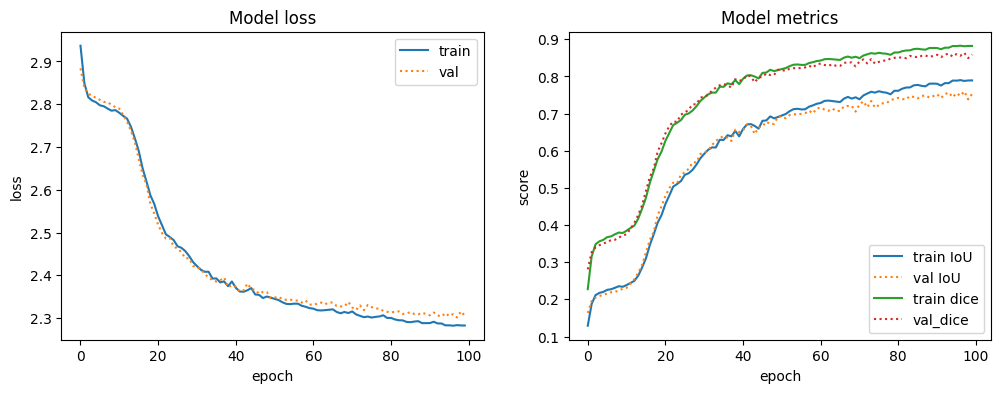

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

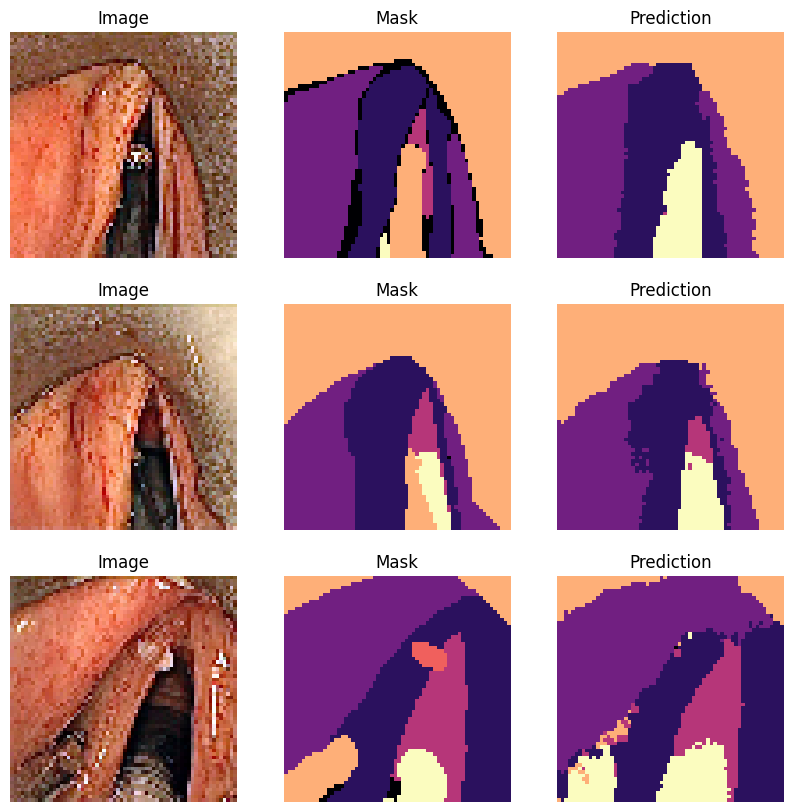

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota